Using cache found in C:\Users\DELL/.cache\torch\hub\facebookresearch_dinov2_main
C:\Users\DELL/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
C:\Users\DELL/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
C:\Users\DELL/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


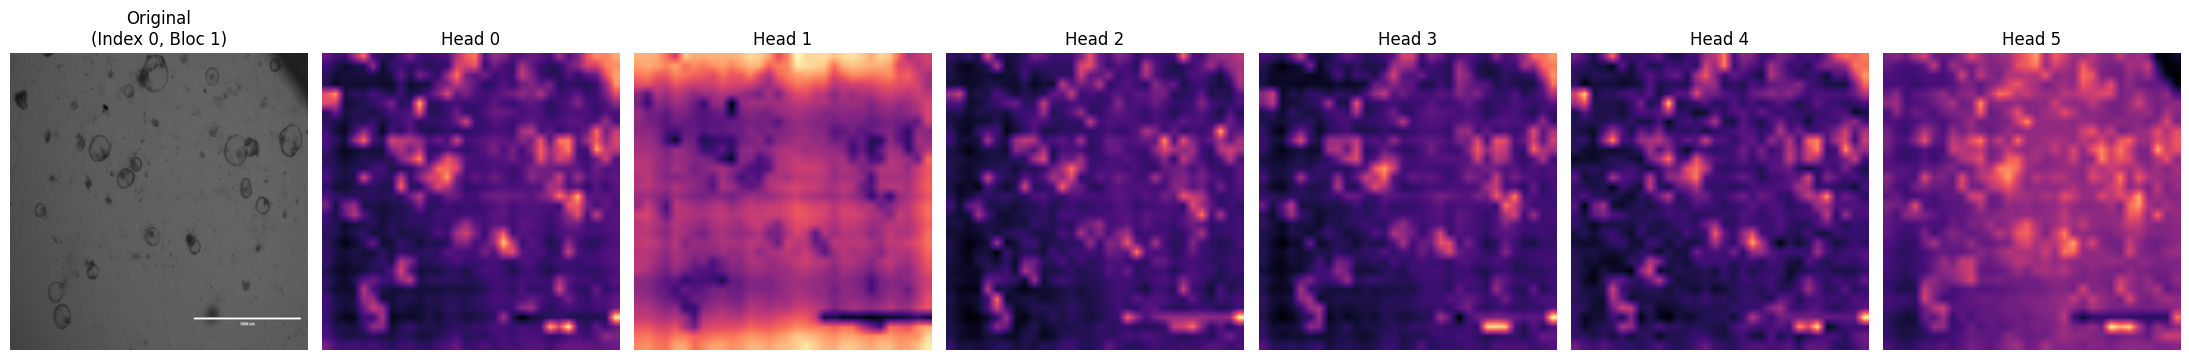

In [ ]:
import h5py
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import math
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14').to(device)
model.eval()

# Img transformation to match model's expected input
img_size = 448 
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def interpolate_pos_encoding(model, x, w, h):
    """Gère l'adaptation des positions apprises à la nouvelle taille d'image."""
    npatch = x.shape[1] - 1
    N = model.pos_embed.shape[1] - 1
    if npatch == N and w == h:
        return model.pos_embed
    
    class_pos_embed = model.pos_embed[:, 0]
    patch_pos_embed = model.pos_embed[:, 1:]
    dim = x.shape[-1]
    
    w0 = h0 = int(math.sqrt(N))
    patch_pos_embed = torch.nn.functional.interpolate(
        patch_pos_embed.reshape(1, w0, h0, dim).permute(0, 3, 1, 2),
        size=(w // 14, h // 14),
        mode='bicubic',
        align_corners=False,
    )
    patch_pos_embed = patch_pos_embed.permute(0, 2, 3, 1).view(1, -1, dim)
    return torch.cat((class_pos_embed.unsqueeze(0), patch_pos_embed), dim=1)

def get_attention_maps(img_size,model,transform,img_index=0, block_index=11, h5_path='data/tellu.h5'):
    """
    block_index : de 0 (entrée) à 11 (sortie) pour ViT-S
    """
    if not os.path.exists(h5_path):
        print(f"Erreur : {h5_path} introuvable.")
        return

    with h5py.File(h5_path, 'r') as hdf:
        group = hdf['train']['images']
        img_names = list(group.keys())
        img_raw = np.array(group[img_names[img_index]])
    
    img_pil = Image.fromarray(img_raw).convert('RGB')
    img_display = img_pil.resize((img_size, img_size))
    img_tensor = transform(img_pil).unsqueeze(0).to(device)

    with torch.no_grad():
        x = model.patch_embed(img_tensor)
        
        cls_token = model.cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_token, x), dim=1)
        x = x + interpolate_pos_encoding(model, x, img_size, img_size)
        
        
        for i in range(block_index):
            x = model.blocks[i](x)
        
        target_block = model.blocks[block_index]
        B, N, C = x.shape
        num_heads = target_block.attn.num_heads
        
        qkv = target_block.attn.qkv(x).reshape(B, N, 3, num_heads, C // num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        
        scale = target_block.attn.scale or (C // num_heads) ** -0.5
        attn = (q @ k.transpose(-2, -1)) * scale
        attn = attn.softmax(dim=-1)

    attentions = attn[0].cpu()
    nh = attentions.shape[0] 
    
    total_tokens = attentions.shape[-1]

    side = int(math.sqrt(total_tokens - 1))
    n_reg = total_tokens - 1 - (side * side) 
    
    start_idx = 1 + n_reg
    map_att = attentions[:, 0, start_idx:].reshape(nh, side, side)

    fig, axes = plt.subplots(1, nh + 1, figsize=(22, 5))
    axes[0].imshow(img_display)
    axes[0].set_title(f"Original\n(Index {img_index}, Bloc {block_index})")
    axes[0].axis('off')
    
    for i in range(nh):
        axes[i+1].imshow(map_att[i], cmap='magma', interpolation='bilinear')
        axes[i+1].set_title(f"Head {i}")
        axes[i+1].axis('off')
    
    plt.tight_layout()
    plt.show()

# # Tests 
# for i in range(12):
#     get_attention_maps(img_index=80, block_index=i)
get_attention_maps(img_index=0, block_index=1)

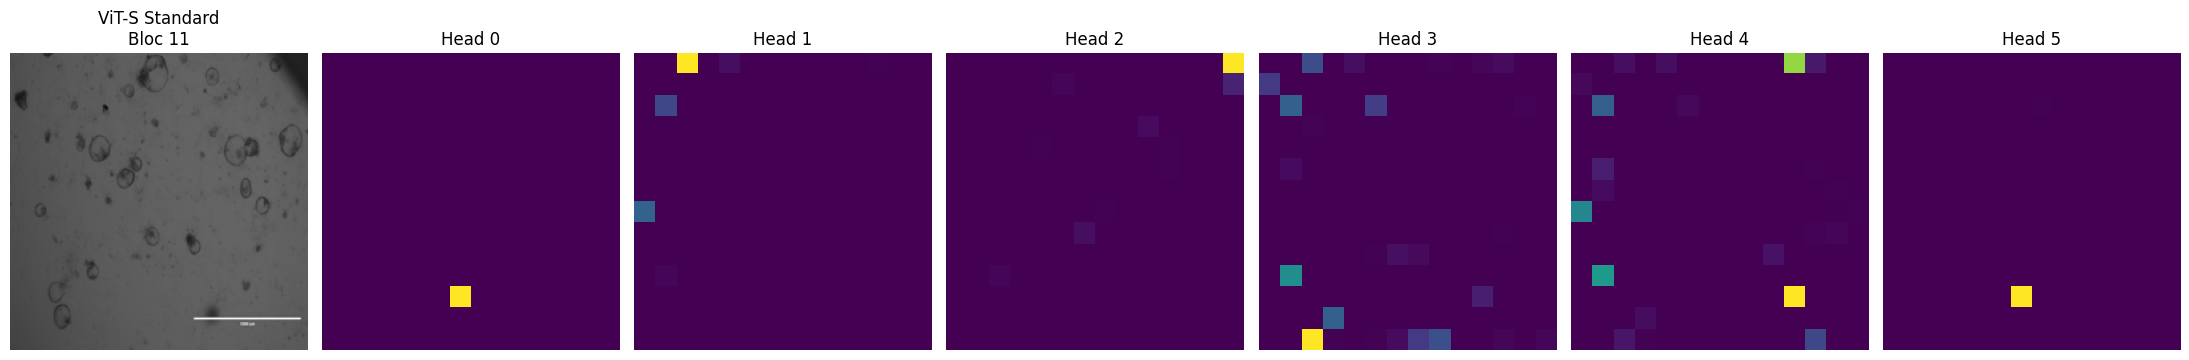

In [25]:
import h5py
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, models
from PIL import Image
import math
import os
import timm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = timm.create_model('vit_small_patch16_224', pretrained=True).to(device)
model.eval()

# Paramètres de transformation (Identiques pour la comparaison)
img_size = 224 
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def get_vit_attention_maps(img_size,model,transform, img_index=0, block_index=11, h5_path='data/tellu.h5'):
    if not os.path.exists(h5_path):
        print(f"Erreur : {h5_path} introuvable.")
        return

    with h5py.File(h5_path, 'r') as hdf:
            group = hdf['train']['images']
            img_raw = np.array(group[list(group.keys())[img_index]])
        
    img_pil = Image.fromarray(img_raw).convert('RGB')
    img_for_display = img_pil.resize((img_size, img_size))
    img_tensor = transform(img_pil).unsqueeze(0).to(device)

    with torch.no_grad():
        # Préparation des tokens
        x = model.patch_embed(img_tensor)
        x = torch.cat((model.cls_token.expand(x.shape[0], -1, -1), x), dim=1)
        x = x + model.pos_embed 
        
        for i in range(block_index):
            x = model.blocks[i](x)
        
        # Attention computation for the target block
        target_block = model.blocks[block_index]
        B, N, C = x.shape
        num_heads = target_block.attn.num_heads
        
        # Access to queries, keys, values of timm model
        qkv = target_block.attn.qkv(x).reshape(B, N, 3, num_heads, C // num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        
        attn = (q @ k.transpose(-2, -1)) * target_block.attn.scale
        attn = attn.softmax(dim=-1)

    attentions = attn[0].cpu()
    nh = attentions.shape[0]
    side = int(math.sqrt(attentions.shape[-1] - 1))
    map_att = attentions[:, 0, 1:].reshape(nh, side, side)

    # Plots
    fig, axes = plt.subplots(1, nh + 1, figsize=(22, 5))
    axes[0].imshow(img_for_display)
    axes[0].set_title(f"ViT-S Standard\nBloc {block_index}")
    axes[0].axis('off')
    
    for i in range(nh):
        axes[i+1].imshow(map_att[i], cmap='viridis')
        axes[i+1].set_title(f"Head {i}")
        axes[i+1].axis('off')
    
    plt.tight_layout()
    plt.show()

# # Tests
# for i in range(12):     
#     get_vit_attention_maps(img_size,model,transform,img_index=80, block_index=i)

get_vit_attention_maps(img_size,model,transform,img_index=0, block_index=11)

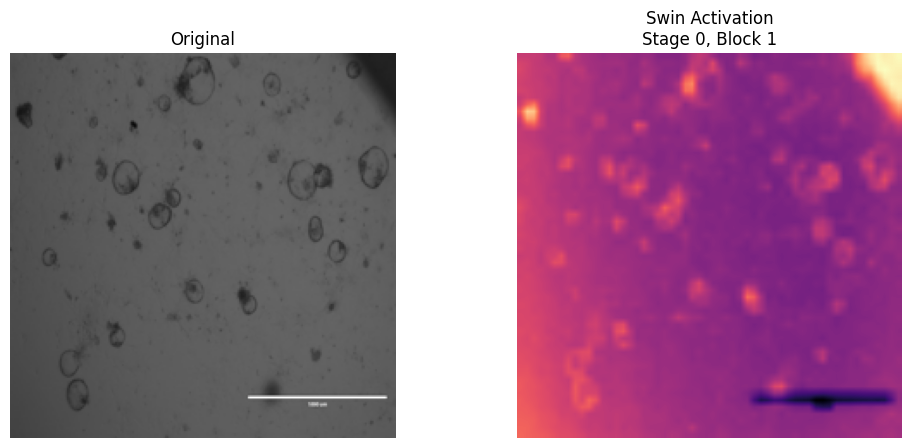

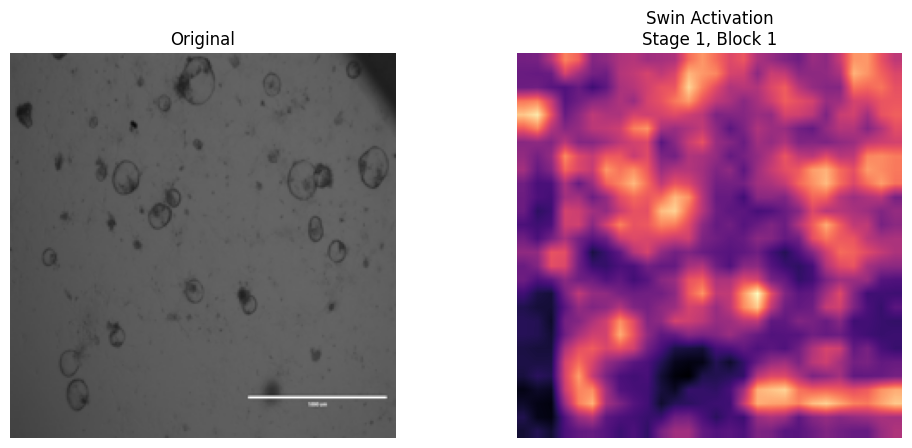

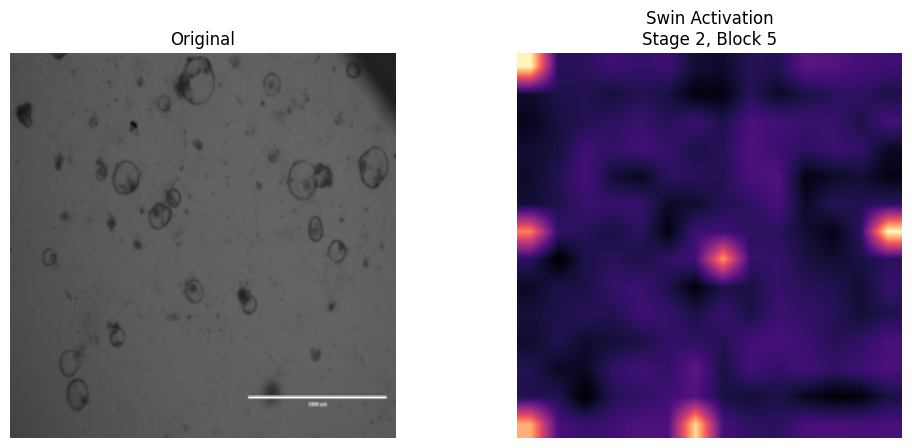

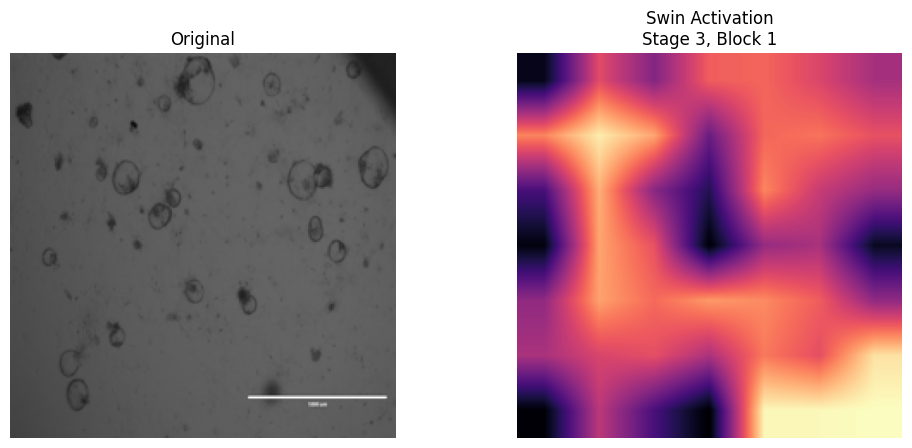

In [24]:
def get_swin_attention_maps(img_size, model, transform, img_index=0, stage_index=0, block_index=0, h5_path='data/tellu.h5'):
    with h5py.File(h5_path, 'r') as hdf:
        group = hdf['train']['images']
        img_raw = np.array(group[list(group.keys())[img_index]])
    
    img_pil = Image.fromarray(img_raw).convert('RGB')
    img_for_display = img_pil.resize((img_size, img_size))
    img_tensor = transform(img_pil).unsqueeze(0).to(device)

    # Use of a Hook to get the data
    activation = {}
    def get_activation_hook(name):
        def hook(model, input, output):
            activation['value'] = output.detach()
        return hook

    target_block = model.layers[stage_index].blocks[block_index]
    handle = target_block.register_forward_hook(get_activation_hook('target'))

    with torch.no_grad():
        model(img_tensor)
    
    x = activation['value']
    
    if x.dim() == 3:
        B, L, C = x.shape
        H = W = int(math.sqrt(L))
        x = x.view(B, H, W, C)
    
    # Activation map computation
    map_activation = x[0].mean(-1).cpu().numpy()

    handle.remove()

    # Plots
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    ax[0].imshow(img_for_display)
    ax[0].set_title("Original")
    
    map_activation = (map_activation - map_activation.min()) / (map_activation.max() - map_activation.min() + 1e-8)
    ax[1].imshow(map_activation, cmap='magma', interpolation='bilinear')
    ax[1].set_title(f"Swin Activation\nStage {stage_index}, Block {block_index}")
    
    for a in ax: a.axis('off')
    plt.show()

get_swin_attention_maps(img_size, model_swin, transform, img_index=0, stage_index=0, block_index=1)

get_swin_attention_maps(img_size, model_swin, transform, img_index=0, stage_index=1, block_index=1)

get_swin_attention_maps(img_size, model_swin, transform, img_index=0, stage_index=2, block_index=5)

get_swin_attention_maps(img_size, model_swin, transform, img_index=0, stage_index=3, block_index=1)
